In [ ]:
# ============================================================
# 🧹 결측치/이상치 전처리 → RandomForest 회귀 학습/평가 통합 스크립트
#  - 입력: /mnt/data/아파트_거리정보_통합추가.csv
#  - 타깃: 보증금(만원) (필요시 TARGET_COL 변경)
#  - 출력: 성능지표, 중요피처, 전처리/예측 결과 파일
# ============================================================

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# -----------------------------
# 설정
# -----------------------------
INPUT_PATH  = "/content/아파트_거리정보_통합추가.csv"

In [7]:
df = pd.read_csv(INPUT_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214 entries, 0 to 1213
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   시군구      1214 non-null   object 
 1   단지명      1214 non-null   object 
 2   전용면적(㎡)  1214 non-null   float64
 3   계약년월     1214 non-null   int64  
 4   계약일      1214 non-null   int64  
 5   보증금(만원)  1214 non-null   int64  
 6   층        1214 non-null   int64  
 7   건축년도     1214 non-null   int64  
 8   계약구분     1214 non-null   object 
 9   위도       1214 non-null   float64
 10  경도       1214 non-null   float64
 11  학교거리_m   1214 non-null   int64  
 12  최근접학교명   1214 non-null   object 
 13  지하철거리_m  1214 non-null   int64  
 14  최근접지하철명  1214 non-null   object 
 15  마트거리_m   1214 non-null   int64  
 16  최근접마트명   1214 non-null   object 
dtypes: float64(3), int64(8), object(6)
memory usage: 161.4+ KB


In [21]:
# ============================================================
# 🧹 특정 컬럼(위도, 경도, 최근접학교명, 최근접지하철명, 최근접마트명) 삭제 코드
# ============================================================

df.columns = df.columns.str.strip()  # 혹시 모를 공백 제거

# 2️⃣ 삭제할 컬럼 목록 지정
cols_to_drop = ["위도", "경도", "최근접학교명", "최근접지하철명", "최근접마트명"]

# 3️⃣ 존재하는 컬럼만 삭제 (없는 경우 자동 무시)
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=cols_to_drop)

print(f"✅ 삭제된 컬럼: {cols_to_drop}")
print(f"📊 현재 남은 컬럼 수: {df.shape[1]}개")

# 4️⃣ 결과 저장
output_path = "아파트_거리정보_통합추가_컬럼삭제후.csv"
df.to_csv(output_path, index=False)
print(f"💾 저장 완료: {output_path}")


✅ 삭제된 컬럼: []
📊 현재 남은 컬럼 수: 12개
💾 저장 완료: 아파트_거리정보_통합추가_컬럼삭제후.csv


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214 entries, 0 to 1213
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   시군구      1214 non-null   object 
 1   단지명      1214 non-null   object 
 2   전용면적(㎡)  1214 non-null   float64
 3   계약년월     1214 non-null   int64  
 4   계약일      1214 non-null   int64  
 5   보증금(만원)  1214 non-null   int64  
 6   층        1214 non-null   int64  
 7   건축년도     1214 non-null   int64  
 8   계약구분     1214 non-null   object 
 9   학교거리_m   1214 non-null   int64  
 10  지하철거리_m  1214 non-null   int64  
 11  마트거리_m   1214 non-null   int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 113.9+ KB


In [24]:

TARGET_COL  = "보증금(만원)"       # 타깃 컬럼명
TEST_SIZE   = 0.2
RANDOM_SEED = 42
N_ESTIMATORS= 300

# 출력 파일
OUT_CLEAN_CSV   = "cleaned_dataset.csv"
OUT_RESULT_CSV  = "rf_test_predictions.csv"
OUT_FEATURE_CSV = "rf_feature_importance.csv"

# -----------------------------
# 1) 데이터 로드
# -----------------------------

df.columns = df.columns.str.strip()
df_orig = df.copy()

if TARGET_COL not in df.columns:
    raise ValueError(f"타깃 컬럼 '{TARGET_COL}' 이(가) 데이터에 없습니다. 컬럼명을 확인하세요. 현재 컬럼들: {list(df.columns)}")

# -----------------------------
# 2) 결측치 처리
#   - 수치형: 중앙값
#   - 범주형: 최빈값(없으면 '미상')
# -----------------------------
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# 타깃은 결측치 제거(학습 불가)
df = df[~df[TARGET_COL].isna()].copy()

# 수치형 결측치
for c in num_cols:
    med = df[c].median() if c in df.columns else None
    if med is not None:
        df[c] = df[c].fillna(med)

# 범주형 결측치
for c in cat_cols:
    if c not in df.columns:
        continue
    mode_vals = df[c].mode(dropna=True)
    fillv = mode_vals.iloc[0] if not mode_vals.empty else "미상"
    df[c] = df[c].astype(str).str.strip().replace({"": np.nan})
    df[c] = df[c].fillna(fillv)

# -----------------------------
# 3) 이상치 처리
#   - 수치형 피처: IQR 윈저라이징(하한/상한 캡핑)
#   - 타깃: 과도한 이상치는 행 제거(IQR k=3: 완화)
# -----------------------------
def winsorize_iqr(series: pd.Series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - k*iqr, q3 + k*iqr
    return series.clip(lower=low, upper=high)

# 타깃 행 제거 (완화된 기준 k=3)
def remove_target_outliers(df: pd.DataFrame, target: str, k=3.0):
    y = df[target]
    q1, q3 = y.quantile(0.25), y.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - k*iqr, q3 + k*iqr
    mask = (y >= low) & (y <= high)
    return df[mask].copy(), int((~mask).sum())

# 타깃 이상치 제거
df, removed_cnt = remove_target_outliers(df, TARGET_COL, k=3.0)
print(f"🧹 타깃 이상치 제거: {removed_cnt}행 제거 (k=3.0)")

# 수치형 피처 윈저라이징(타깃 제외)
feature_num_cols = [c for c in num_cols if c in df.columns and c != TARGET_COL]
for c in feature_num_cols:
    df[c] = winsorize_iqr(df[c].astype(float), k=1.5)

# -----------------------------
# 4) 피처/타깃 분리 & 인코딩
# -----------------------------
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(float)

# 범주형 인코딩 (간단 LabelEncoder: 트리모델에 적합)
# 주의: 학습/테스트 누수 방지를 위해 train_test_split 후에 fit/transform을 분리하는 것도 가능하지만,
# 여기서는 재현 간소화를 위해 전체에 동일 치환(고정 시드) → 카테고리 폭이 큰 경우는 OneHotEncoder 고려
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c].astype(str))
    encoders[c] = le

# -----------------------------
# 5) 학습/검증 분리
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

# -----------------------------
# 6) Random Forest 학습
# -----------------------------
rf = RandomForestRegressor(
    n_estimators=N_ESTIMATORS,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# -----------------------------
# 7) 평가
# -----------------------------
pred = rf.predict(X_test)

mae  = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2   = r2_score(y_test, pred)

print("\n📊 [Random Forest 성능]")
print(f"MAE (평균절대오차): {mae:,.2f}")
print(f"RMSE(평균제곱근오차): {rmse:,.2f}")
print(f"R²  (결정계수):     {r2:.4f}")

# -----------------------------
# 8) 중요 피처 상위 20
# -----------------------------
feat_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print("\n🔎 중요 피처 Top 20")
print(feat_imp.head(20).to_string(index=False))

# -----------------------------
# 9) 결과 저장
# -----------------------------
# 정제 데이터 저장
df.to_csv(OUT_CLEAN_CSV, index=False)

# 테스트셋 예측 결과 저장
out_test = X_test.copy()
out_test[TARGET_COL] = y_test.values
out_test["예측값(보증금)"] = pred
out_test["차액(예측-실제)"] = out_test["예측값(보증금)"] - out_test[TARGET_COL]
out_test.to_csv(OUT_RESULT_CSV, index=False)

# 중요도 저장
feat_imp.to_csv(OUT_FEATURE_CSV, index=False)

print(f"\n💾 저장 완료:")
print(f"- 전처리 데이터: {os.path.abspath(OUT_CLEAN_CSV)}")
print(f"- 테스트 예측결과: {os.path.abspath(OUT_RESULT_CSV)}")
print(f"- 중요 피처:      {os.path.abspath(OUT_FEATURE_CSV)}")


🧹 타깃 이상치 제거: 0행 제거 (k=3.0)

📊 [Random Forest 성능]
MAE (평균절대오차): 5,307.99
RMSE(평균제곱근오차): 8,310.91
R²  (결정계수):     0.9357

🔎 중요 피처 Top 20
feature  importance
   건축년도    0.415414
전용면적(㎡)    0.415076
 마트거리_m    0.037246
 학교거리_m    0.035010
      층    0.017081
    계약일    0.016962
   계약년월    0.016514
지하철거리_m    0.015723
    단지명    0.011765
   계약구분    0.011104
    시군구    0.008106

💾 저장 완료:
- 전처리 데이터: /content/cleaned_dataset.csv
- 테스트 예측결과: /content/rf_test_predictions.csv
- 중요 피처:      /content/rf_feature_importance.csv


✅ 현재 폰트 설정: ['NanumGothic']


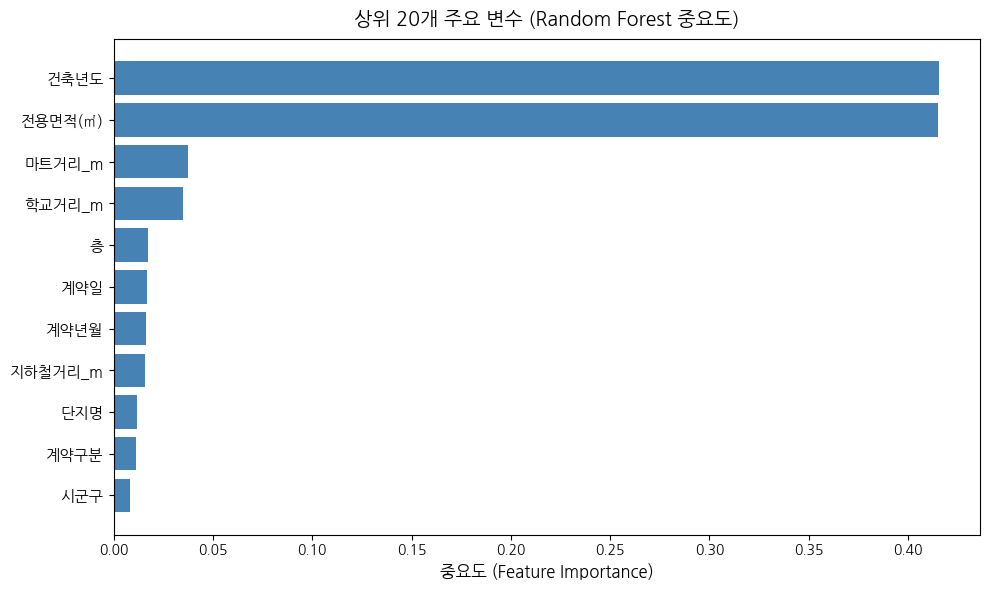

In [25]:
# ============================================================
# 📈 Random Forest Feature Importance 시각화 (한글 완벽 지원)
# ============================================================

import os
import platform
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# ============================================================
# 1️⃣ 한글 폰트 설정 (OS 자동 감지)
# ============================================================
def set_korean_font():
    mpl.rcParams["axes.unicode_minus"] = False  # 마이너스 기호 깨짐 방지
    sysname = platform.system()

    if sysname == "Windows":
        mpl.rcParams["font.family"] = "Malgun Gothic"  # 윈도우: 맑은 고딕
    elif sysname == "Darwin":
        mpl.rcParams["font.family"] = "AppleGothic"    # macOS: 애플 고딕
    else:
        # Linux (예: Colab, Ubuntu 등)
        nanum_font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
        if not os.path.exists(nanum_font_path):
            import subprocess
            subprocess.run(["apt-get", "-qq", "update"], check=True)
            subprocess.run(["apt-get", "-qq", "-y", "install", "fonts-nanum"], check=True)
        if os.path.exists(nanum_font_path):
            fm.fontManager.addfont(nanum_font_path)
            mpl.rcParams["font.family"] = "NanumGothic"
        else:
            # fallback
            mpl.rcParams["font.family"] = "DejaVu Sans"
    # 캐시 리로드
    fm._load_fontmanager(try_read_cache=False)
    print(f"✅ 현재 폰트 설정: {mpl.rcParams['font.family']}")

set_korean_font()


TARGET_COL = "보증금(만원)"
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# ============================================================
# 3️⃣ 범주형 인코딩
# ============================================================
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(include=[np.number]).columns

for col in cat_cols:
    X[col] = X[col].astype(str).str.strip()
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# ============================================================
# 4️⃣ 데이터 분리 및 모델 학습
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# ============================================================
# 5️⃣ Feature Importance 계산
# ============================================================
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:20]  # 상위 20개
top_features = np.array(X.columns)[indices]
top_importances = importances[indices]

# ============================================================
# 6️⃣ 시각화
# ============================================================
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), top_importances[::-1], color="steelblue")
plt.yticks(range(len(indices)), top_features[::-1], fontsize=11)
plt.xlabel("중요도 (Feature Importance)", fontsize=12)
plt.title("상위 20개 주요 변수 (Random Forest 중요도)", fontsize=14, pad=10)
plt.tight_layout()
plt.show()